                                                            M2-AMSS-CSC
<div style="text-align: center;">
    <img src="./logo_ens.png">
</div>

<div style="text-align: center;">
    <H1>Techniques et outils pour la preuve de concepts</H1>
    Alberic Junior DASSI FEUSSOUO
</div>

 <H3><i> Machine learning-based approach for online fault Diagnosis of Discrete Event System (Saddem et al. - 2022 )</H3> 

# 3. Préparation des données 

Le but de cette étape est de formater les données d'entrée de notre algorithme. Il est alors question de transformer le fichier CSV des données brutes du système en un fichier contenant des données sous forme de trames tel que l’illustre la figure ci-dessous(<i>Paragraphe 3.5</i>).
<div style="text-align: center;">
    <img src="./trame_de_donnees.png">
</div> <br>
L’algorithme de LSTM recevra une séquence de N vecteurs d’observations passées : 
$X=[x_{t-N},x_{t-N+1},… ,x_{t-1}, x{t}]$
Où chaque $x_i$ contient :

* Les valeurs binaires des capteurs
* Les valeurs binaires des actionneurs
* La durée depuis la dernière observation. 

Une fois que cela sera fait, les données doivent êtres scindées en données d’entrainement et en données de test pour permettre l’entrainement de l’algorithme sur des données jamais vues et éviter par conséquent le sur apprentissage. 

# <H3>3.1. Bibliothèques nécessaires
Nous aurons besoins des bibliotheques permattant: 
* Les caluculs numeriques et la manipulation de vecteurs (numpy, panda)
* la repartition des donnees pour entrainement et test
* Encoder toutes les classes (C0, C1,...,C7)

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# <H3> 3.2. Modèle du préparateur de données.
Une fois de plus, nous optons pour le paradigme de la Programmtion Orientee Objet. <br>
Le « préparateur » de données est alors une classe qui a :
* Deux attributs principaux : Les données brutes générées par le système (contenues dans le fichier CSV) et les états encodés du système (C0 à C7)
* Des comportements/Methodes : La création des séquences temporelles, l'ajout de composante comme le temps écoulé, la division des données en données d'entrainement, de test et de validation.

In [10]:
class Preparateur:
    #Classe pour préparer les données selon l'approche de l'article
    
    def __init__(self, dataset_path='sap_dataset.csv'):
        #(le constructeur)
        #On charge le dataset généré par le simulateur

        print("Chargement des données")
        self.df = pd.read_csv(dataset_path)
        
        # Encoder les états (C0-C7) en valeurs numériques
        self.label_encoder = LabelEncoder()
        self.df['state_encoded'] = self.label_encoder.fit_transform(self.df['state'])
        
        print(f" Données chargées : {len(self.df)} échantillons")
        print(f" Classes : {self.label_encoder.classes_}")
        
    def create_sequences(self, n_steps=50):
        #Ici, on crée des séquences temporelles pour l'algorithme
        #Paramètres:
        #n_steps (int): Nombre de pas de temps passés à considérer (N dans l'article)
            #Dans l'article utilise N=50
        #Retour:
        #X : array de shape (n_samples, n_steps, n_features)
            #Séquences d'entrée
        #y : array de shape (n_samples,)
            #Labels (états du système)
        print(f"\nCréation de séquences avec N={n_steps} pas de temps...")
        
        # Colonnes de features (capteurs + actionneurs)
        feature_cols = ['capteur_1', 'capteur_2', 'moteur']
        
        X = []
        y = []
        
        current_sequence = []
         # On parcourt les données par groupes de cycles
        for idx in range(len(self.df)):
            row = self.df.iloc[idx]
            
            # On ajoute le vecteur actuel à la séquence
            features = row[feature_cols].values
            current_sequence.append(features)
            
            # Si on a assez de pas de temps
            if len(current_sequence) >= n_steps:
                X.append(np.array(current_sequence[-n_steps:]))
                y.append(row['state_encoded'])
            
            # On réinitialise si nouveau cycle (détection par changement brutal) ou si on atteint la fin d'un groupe
            if idx < len(self.df) - 1:
                next_timestamp = pd.to_datetime(self.df.iloc[idx + 1]['timestamp'])
                curr_timestamp = pd.to_datetime(row['timestamp'])
                time_diff = (next_timestamp - curr_timestamp).total_seconds()
                
                # Si saut temporel > 1 seconde, c'est un nouveau cycle
                if time_diff > 1.0:
                    current_sequence = []
        
        X = np.array(X)
        y = np.array(y)
        
        print(f" {len(X)} séquences créées")
        print(f" Shape de X : {X.shape}")  # (n_samples, n_steps, n_features)
        print(f" Shape de y : {y.shape}")  # (n_samples,)
        
        return X, y
    
    def add_time_features(self, n_steps=50):
        #Cette fonction permet d'ajouter la durée relative (temps écoulé)
        
        print(f"\nCréation de séquences avec durées temporelles...")
        
        feature_cols = ['capteur_1', 'capteur_2', 'moteur']
        
        X = []
        y = []
        
        current_sequence = []
        
        for idx in range(len(self.df)):
            row = self.df.iloc[idx]
            
            # On calcule la durée depuis le dernier changement
            if idx > 0:
                curr_time = pd.to_datetime(row['timestamp'])
                prev_time = pd.to_datetime(self.df.iloc[idx - 1]['timestamp'])
                duration = (curr_time - prev_time).total_seconds()
            else:
                duration = 0.0
            
            # Vecteur : [capteur_1, capteur_2, moteur, durée]
            features = np.append(row[feature_cols].values, duration)
            current_sequence.append(features)
            
            if len(current_sequence) >= n_steps:
                X.append(np.array(current_sequence[-n_steps:]))
                y.append(row['state_encoded'])
            
            # Détection de nouveau cycle
            if idx < len(self.df) - 1:
                next_timestamp = pd.to_datetime(self.df.iloc[idx + 1]['timestamp'])
                curr_timestamp = pd.to_datetime(row['timestamp'])
                time_diff = (next_timestamp - curr_timestamp).total_seconds()
                
                if time_diff > 1.0:
                    current_sequence = []
        
        X = np.array(X)
        y = np.array(y)
        
        print(f" {len(X)} séquences créées avec durées")
        print(f" Shape de X : {X.shape}")  # (n_samples, n_steps, 4)
        
        return X, y
    
    def split_data(self, X, y, test_size=0.2, val_size=0.2):
        
        #Cette fonction divise les données en train/validation/test (secteion 3.2)
        
        #Ici on fait une division simple pour commencer
        
        print(f"\nDivision des données...")
        
        # Données de test
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        # Données train et validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size/(1-test_size), 
            random_state=42, stratify=y_temp
        )
        
        print(f" Train : {len(X_train)} échantillons")
        print(f" Validation : {len(X_val)} échantillons")
        print(f" Test : {len(X_test)} échantillons")
        
        return X_train, X_val, X_test, y_train, y_val, y_test
    
    def visualize_class_distribution(self, y):
        #Pour avoir une idee visuelle de la distribution des classes
        
        plt.figure(figsize=(10, 6))
        
        unique, counts = np.unique(y, return_counts=True)
        class_names = self.label_encoder.inverse_transform(unique)
        
        plt.bar(class_names, counts, color='steelblue', edgecolor='black')
        plt.xlabel('État du système', fontsize=12)
        plt.ylabel('Nombre d\'échantillons', fontsize=12)
        plt.title('Distribution des classes dans le dataset', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Afficher les statistiques
        print("\nDistribution des classes :")
        for name, count in zip(class_names, counts):
            percentage = (count / len(y)) * 100
            print(f"  {name:25s} : {count:5d} ({percentage:5.2f}%)")




# <H3> 3.3. Lancement de la préparation des données 

PRÉPARATION DES DONNÉES POUR LE MODÈLE LSTM
Chargement des données
 Données chargées : 1200 échantillons
 Classes : ['C0' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7']

Séquences simples (capteurs + moteur)

Création de séquences avec N=50 pas de temps...
 1151 séquences créées
 Shape de X : (1151, 50, 3)
 Shape de y : (1151,)


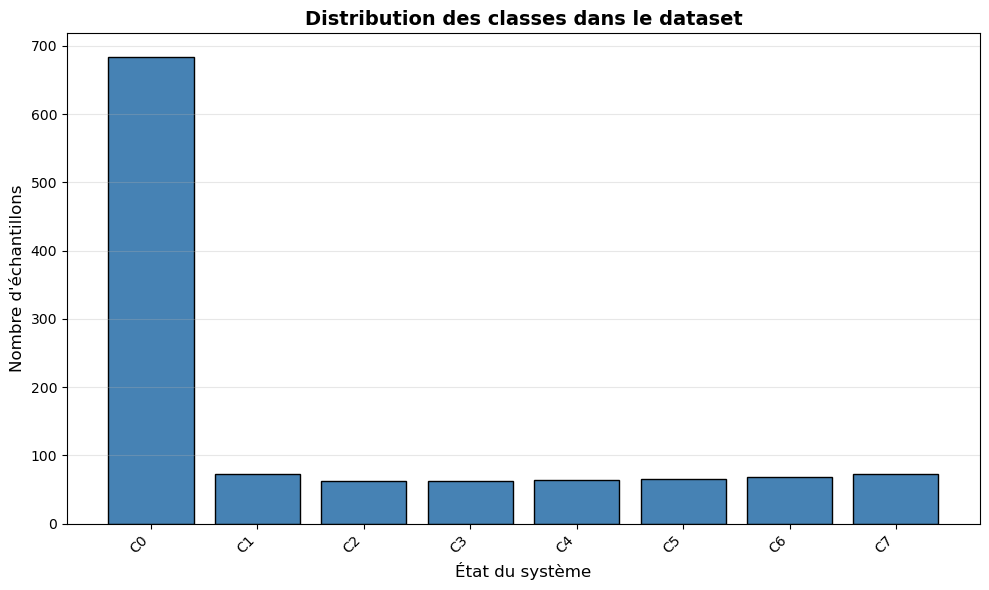


Distribution des classes :
  C0                        :   684 (59.43%)
  C1                        :    73 ( 6.34%)
  C2                        :    63 ( 5.47%)
  C3                        :    62 ( 5.39%)
  C4                        :    64 ( 5.56%)
  C5                        :    65 ( 5.65%)
  C6                        :    68 ( 5.91%)
  C7                        :    72 ( 6.26%)

Séquences avec durées temporelles

Création de séquences avec durées temporelles...
 1151 séquences créées avec durées
 Shape de X : (1151, 50, 4)

Division des données...
 Train : 690 échantillons
 Validation : 230 échantillons
 Test : 231 échantillons

Sauvegarde des données préparées...
 Données sauvegardées dans 'prepared_data.npz'

STATISTIQUES FINALES
Forme des données d'entrée : (690, 50, 4)
  - Nombre d'échantillons d'entraînement : 690
  - Nombre de pas de temps (N) : 50
  - Nombre de features : 4

Nombre de classes : 8
Classes : ['C0' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7']


In [11]:
if __name__ == "__main__":
    print("="*70)
    print("PRÉPARATION DES DONNÉES POUR LE MODÈLE LSTM")
    print("="*70)
    
    # 1. Charger et préparer les données
    data_prep = Preparateur('sap_dataset.csv')
    
    # 2. Créer les séquences temporelles (version simple)
    print("\n" + "="*70)
    print("Séquences simples (capteurs + moteur)")
    print("="*70)
    X, y = data_prep.create_sequences(n_steps=50)
    
    # 3. Visualiser la distribution
    data_prep.visualize_class_distribution(y)
    
    # 4. Créer les séquences avec durées (version avancée)
    print("\n" + "="*70)
    print("Séquences avec durées temporelles")
    print("="*70)
    X_time, y_time = data_prep.add_time_features(n_steps=50)
    
    # 5. Diviser les données
    X_train, X_val, X_test, y_train, y_val, y_test = data_prep.split_data(X_time, y_time)
    X_train = X_train.astype("float32")
    X_val = X_val.astype("float32")
    X_test = X_test.astype("float32")

    y_train = y_train.astype("int64")
    y_val = y_val.astype("int64")
    y_test = y_test.astype("int64")    
    
    # 6. Sauvegarder les données préparées
    print("\nSauvegarde des données préparées...")
    np.savez('prepared_data.npz',
             X_train=X_train, X_val=X_val, X_test=X_test,
             y_train=y_train, y_val=y_val, y_test=y_test)
    print(" Données sauvegardées dans 'prepared_data.npz'")
    
    # 7. Statistiques finales
    print("\n" + "="*70)
    print("STATISTIQUES FINALES")
    print("="*70)
    print(f"Forme des données d'entrée : {X_train.shape}")
    print(f"  - Nombre d'échantillons d'entraînement : {X_train.shape[0]}")
    print(f"  - Nombre de pas de temps (N) : {X_train.shape[1]}")
    print(f"  - Nombre de features : {X_train.shape[2]}")
    print(f"\nNombre de classes : {len(np.unique(y))}")
    print(f"Classes : {data_prep.label_encoder.classes_}")